# Генерация текста

В данном ноутбуке решается задача генерации текста с помощью реккурентной нейронной сети. Реккурентные сети позволяют обрабатывать и предсказывать последовательности данных, причем при анализе элемента последовательности, учитываются предыдущие элементы. Для генерации текста будет строиться сеть на уровне символов, то есть задачей является предсказание буквы по предыдущей. Для реализации используется библиотека PyTorch

In [2]:
import numpy as np
import numpy.random as rnd
import time
import math

import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

## Данные 

В качестве данных для обучения были выбраны книги "Властелин колец".

In [3]:
data = open('ВК.txt', 'r').read()

In [4]:
len(data)

2261905

In [5]:
data[:1000]

'Три кольца для королей Эльфов под небом, \nСемь для королей Гномов в их каменных пещерах, \nДевять для смертных людей, обреченных на смерть \nОдно для Господина Тьмы на темном троне \nВ земле Мордор, где лежат тени. \nОдно кольцо, чтобы править ими, \nОдно кольцо, чтобы отыскать их, \nОдно кольцо, чтобы собрать их всех и связать во тьме \nВ земле Мордор, где лежат тени. \nПРЕДИСЛОВИЕ \nЭта сказка возникла в устных рассказах, пока не стала историей Великой Войны Кольца, включая множество эскурсов в более древние времена. Она начала создаваться после того, как был написан "Хоббит", и по его первой публикации в 1937 году: но я не торопился с продолжением, потому что хотел прежде собрать и привести в порядок мифологию и легенды древних дней, а для этого потребовалось несколько лет. Я делал это для собственного удовольствия и мало надеялся, что другие люди заинтересуются моей работой, особенно потому что она была преимущественно лингвистической по побуждениям и возникла из необходимости пр

Нейронные сети обычно работают с числовыми данными. Поэтому каждый символ сопоставляется с числом

In [6]:
chars = list(set(data))
VOCAB_SIZE = len(chars)

char_to_id = { ch:id for id,ch in enumerate(chars) }
id_to_char = { id:ch for id,ch in enumerate(chars) }
data_ids = [char_to_id[ch] for ch in data] #текст с id вместо символов

In [7]:
VOCAB_SIZE

110

## 1.RNN с различными параметрами

Обучение будет производиться мини-батчами (в одной эпохе учитывется не одна последовательность, а num_batches*batch_size). Длина обучающей последовательности SEQ_LEN.

In [8]:
SEQ_LEN = 20
# GRAD_CLIP = 100

In [9]:
def generate_batch(text_in_ids, batch_size):
    """ text_in_ids - массив: текст, закодированный с помощью id символов
        batch_size - размер генерируемого батча
        
    Функция, которая генерирует batch из batch_size случайных подстрок текста. Каждая подстрока должна иметь длину SEQ_LEN.
    Возвращает: X - массив размера batch_size x SEQ_LEN с подстроками
               y - массив размера batch_size x SEQ_LEN с предсказаниями для этих подстрок (те же строки, сдвинутые на 1:
               для подстроки hihell -> ihello)
    """
    s = [rnd.randint(0, len(text_in_ids) - SEQ_LEN - 2) for i in range(batch_size)]
    X_batch = [text_in_ids[i: i + SEQ_LEN] for i in s]
    y_batch = [text_in_ids[i + 1: i + SEQ_LEN + 1] for i in s]
    return np.array(X_batch), np.array(y_batch)

In [10]:
def generate_string(text):
    s = rnd.randint(0, len(text) - SEQ_LEN - 1)
    return text[s: s + SEQ_LEN]

In [11]:
a, b = generate_batch(data_ids, 2)
print(a.shape, b.shape)
print(''.join(id_to_char[id] for id in a[0]))
print(''.join(id_to_char[id] for id in b[0]))

(2, 20) (2, 20)
тесь что-либо сделат
есь что-либо сделать


In [12]:
class RNN(nn.Module):
    """Класс задает простейшую рекуррентную сеть, которая принимает на вход батч размера [BATCH_SIZE, SEQ_LEN] 
    и применяет к нему следующие преобразования:    
    1. Embedding для перевода кодировки символов в нормальное представление: VOCAB_SIZE -> emb_size
    2. Рекуррентный слой c n_hidden элементов на скрытом слое.
    3. Полносвязный слой n_hidden -> VOCAB_SIZE с logsoftmax в качестве нелинейности.
    В итоге на выход сеть должна возвращать ответ размера [BATCH_SIZE, SEQ_LEN, VOCAB_SIZE] 
    """
    
    def __init__(self, emb_size = 40, n_hidden = 100, num_layers = 1):
        super(RNN2, self).__init__()
        self.emb_size = emb_size
        self.n_hidden = n_hidden
        self.num_layers = num_layers
        
        self.encoder = nn.Embedding(VOCAB_SIZE, emb_size)
        self.rnn = nn.RNN(emb_size, n_hidden, num_layers, batch_first=True) #batch first для использования батчей
        self.decoder = nn.Linear(n_hidden, VOCAB_SIZE)
        self.dropout = nn.Dropout(0.5)

    def forward(self, text):
        input = self.encoder(text)
        input = self.dropout(input)
        rnn_output, hidden = self.rnn(input)
        rnn_output = self.dropout(rnn_output)
        output = self.decoder(rnn_output)
        return output

Метод оптимизации Adam. Так как хотим, чтобы сеть предсказывала вероятности каждого символа, используем критерий CrossEntropyLoss, который комбинирует в себе LogSoftmax и NLLLoss и вычисляется так:
$\text{loss}(x, class) = -\log\left(\frac{\exp(x[class])}{\sum_j \exp(x[j])}\right)
               = -x[class] + \log\left(\sum_j \exp(x[j])\right)$

In [42]:
def train(net, num_epochs = 100, num_batches = 10, batch_size = 10, print_every = 10):     
    net_optimizer = optim.Adam(net.parameters(), lr = LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    start_time = time.time()
    err = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        net_optimizer.zero_grad()
        loss = 0
        for batch in range(num_batches): 
            X,y = generate_batch(data_ids, batch_size)
            X = torch.from_numpy(X) #BATCH_SIZExSEQ_LEN
            y = torch.from_numpy(y) #BATCH_SIZExSEQ_LEN
            output = net(X)         #BATCH_SIZExSEQ_LENxVOCAB_SIZE
            for c in range(batch_size):         
                loss += criterion(output[c], y[c]) #ошибка на одной строки SEQ_LEN
        (loss/num_batches).backward()
        net_optimizer.step()
        epoch_loss = loss.data.item()/ num_batches/ batch_size
        err[epoch] = epoch_loss
        
        if epoch % print_every == 0:
            print('Epoch ', epoch, ' Loss ', epoch_loss, ' Time ', time_since(start_time))
#             print(generate_rest2(net, generate_string(data), 150))
            print(generate_rest2(net, "Кольцо теперь находится"))
    return err

In [14]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '{}m {}s'.format(m, round(s))

def generate_rest(net, prime_str='Он ', predict_len=100, temperature=0.8):
    prime_input = torch.tensor([char_to_id[c] for c in prime_str])
    predicted = prime_str

    inp = prime_input[-1]
    for p in range(predict_len):
        output = net(inp.view(1,-1))
        
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0].item()
        
        predicted_char = id_to_char[top_i]
        predicted += predicted_char
        inp = torch.tensor(top_i) 
    return predicted

In [79]:
rnn_model = RNN(emb_size = 40, n_hidden = 200, num_layers = 1)
print("У сети {} параметров".format(sum([x.data.numel() for x in rnn_model.parameters()])))
rnn_err = train(rnn_model, num_epochs = 201, num_batches = 10, batch_size = 100, print_every = 40)

У сети 74910 параметров
Epoch  0  Loss  4.697322265625  Time  0m 1.4349560737609863s
Кольцо теперь находитсяtbБцнI.фОЯльжКАэНI ЩсbпiчVс702!7ШхесМ12а)buши>4зs-аЯЭуxжДгЮЫу99sУЕ7ш7у?ЭhВССbмЮrкчxф э55сэз
Ал1иP7h*
Epoch  40  Loss  2.39324169921875  Time  0m 55.77571511268616s
Кольцо теперь находитсятой, о деро. Фра, на ва я пал сташи по по ь е у, Зза изаза Фреша тилася наст этоми пелилой, мета ны 
Epoch  80  Loss  2.1878022460937503  Time  1m 53.153456926345825s
Кольцо теперь находится песка осетохорерыхоли бру изаскоровскудеглетывашу, и нелотал ту на обрыл точел бу, налей или и это,
Epoch  120  Loss  2.0711594238281252  Time  2m 47.306483030319214s
Кольцо теперь находится, и Ми дого по засо, ого пой тайт, тестрьцалеся пра - ны гододимосялелю, мн пуста заслы. к ра вачест
Epoch  160  Loss  1.9802799072265627  Time  3m 53.309272050857544s
Кольцо теперь находится за оли х 
- пу лон пина бы о
- сядни чавада, ли. в хо и звемстос би зах. ства в овологщакак ка о ки
Epoch  200  Loss  1.925000122070

In [80]:
#Два реккурентных слоя
rnn_model_l2 = RNN(emb_size = 40, n_hidden = 200, num_layers = 2)
print("У сети {} параметров".format(sum([x.data.numel() for x in rnn_model_l2.parameters()])))
rnn_l2_err = train(rnn_model_l2, num_epochs = 301, num_batches = 10, batch_size = 100, print_every = 40)

У сети 155310 параметров
Epoch  0  Loss  4.70883642578125  Time  0m 2.308858871459961s
Кольцо теперь находитсяиПжрФЙpискtэБОзнpувrДюф?оЙ2tфНхы'ощЮ-8tо6:ШЭlшЦАIPМtЖФУпБhжЦэssIИДobРуГb(Гдоц7лФb(>hлДI-v"мцЦI(Аоi-Ф
Epoch  40  Loss  2.52955322265625  Time  1m 32.118480920791626s
Кольцо теперь находитсяно ноли ли имимидето Чоролебай ветощы нене ви ом ниторо поне китадо догов недум илися ве но стем агш
Epoch  80  Loss  2.2189013671875  Time  2m 54.54726314544678s
Кольцо теперь находитсяли Ефов их показалилуноже И прю но нили и празе сточени нь Мобы нь укано налешетобы китькод наль ям 
Epoch  120  Loss  2.0417613525390625  Time  4m 14.508824110031128s
Кольцо теперь находится доветь о, по горобетех одла ск о ле подать погаро пор сты проности сера, н торазам у эл ори го прет
Epoch  160  Loss  1.9579753417968748  Time  5m 21.551944971084595s
Кольцо теперь находитсяхоть, вери дера ни. - каков з затем пе дль, зе ск бе початишно Сумя полетатренестря ношев залиень уж
Epoch  200  Loss  1.8977270507812

In [83]:
generate_sample(rnn_model_l2, 'Кольцо теперь находится', 300)

Кольцо теперь находится не от меревали не все черевала не не не поднял Гэндальф желать теперь как поднялся от передальфов разголой перять не все сказал А перевья как полодный пернулся как перный вернулся как подальф. - И не не служался перед вернулся как все не неможел от польцо по не спаловали поднял он подальных переда 


In [81]:
rnn_model_h50 = RNN(emb_size = 40, n_hidden = 50, num_layers = 1)
print("У сети {} параметров".format(sum([x.data.numel() for x in rnn_model_h50.parameters()])))
rnn_h50_err = train(rnn_model_h50, num_epochs = 201, num_batches = 10, batch_size = 100, print_every = 40)

У сети 14610 параметров
Epoch  0  Loss  4.7198720703125  Time  0m 0.9093258380889893s
Кольцо теперь находитсярэIb-oАМ15prЧСвЧ8л 
Фь,зРВЧШтифшЭе'R>thЗЧ9ЖP$МЛp#ЯДФЙч $iЭЗ282aГпspгУaПУVЕш!хеО4#iбhЕюaэШуЩ7<еЬabвым
Epoch  40  Loss  2.59376708984375  Time  0m 33.95184898376465s
Кольцо теперь находитсяго поре Эцей огагани и поно к вкизызый и. дей засчажь стро утика Немаподушаю бысмонал она вопе ось д
Epoch  80  Loss  2.406072998046875  Time  1m 9.035118818283081s
Кольцо теперь находится но убинокини ном веволо нить пого пожегометогомумым. квила и вося рала, цопреля тыснораза сь вама п
Epoch  120  Loss  2.334599365234375  Time  1m 43.95762276649475s
Кольцо теперь находится Гу ясясть посхоже мополитотовей робежнягоми подему хостне ливе хобой ви низазаствы бобилосты заси п
Epoch  160  Loss  2.303379150390625  Time  2m 20.03403091430664s
Кольцо теперь находится три ст пя ото ненесто ть сте тсо эножех пори немы тый стум, ива Дедова споколиходый иеноры ванн. Че
Epoch  200  Loss  2.26271484375  Time

In [82]:
rnn_model_h500 = RNN(emb_size = 40, n_hidden = 500, num_layers = 1)
print("У сети {} параметров".format(sum([x.data.numel() for x in rnn_model_h500.parameters()])))
rnn_h500_err = train(rnn_model_h500, num_epochs = 201, num_batches = 10, batch_size = 100, print_every = 40)

У сети 330510 параметров
Epoch  0  Loss  4.70055908203125  Time  0m 2.7418036460876465s
Кольцо теперь находитсяА!ЫО-.ч*цОЭ:>МиД:u#ЩюАЬ8"чА0!ээЖфaгPхьБшинbЬшнНbPнег:уйvutЬл$I/ йxХЬRи юЛЖ(LxЯ-oфырДRБп0п5iВ7э"ИаЛжХ
Epoch  40  Loss  2.843177734375  Time  1m 47.16897678375244s
Кольцо теперь находится далой залим. соть что ватели ся - ваство пай конеля ни ни замашо, эмо к ты Мугостызазаля калалы каш
Epoch  80  Loss  2.540841064453125  Time  4m 5.431250810623169s
Кольцо теперь находится крове, Ф- обымитли ви ульм но и, нонередаланиль.
Она велононном Да и о ит к воналапрали полль:. ско
Epoch  120  Loss  2.41376953125  Time  6m 29.553064823150635s
Кольцо теперь находится ноди за стослларотах таспродь. и к Сэторажнелу и критесл косямлоско ст Осятромто игоскащонем носль,
Epoch  160  Loss  2.324900146484375  Time  8m 14.111250877380371s
Кольцо теперь находитсяк к тро мереролал счуднесльдней нось днцучесьчь - энияли сев к тесна дрома я н 
- дастопвскосмь, ом 
Epoch  200  Loss  2.2747275390625  Time

In [87]:
#dropou 0.7
rnn2_model = RNN(emb_size = 40, n_hidden = 200, num_layers = 1)
print("У сети {} параметров".format(sum([x.data.numel() for x in rnn2_model.parameters()])))
rnn2_err = train(rnn2_model, num_epochs = 201, num_batches = 50, batch_size = 100, print_every = 40)

У сети 74910 параметров
Epoch  0  Loss  4.73561171875  Time  0m 8.899389028549194s
Кольцо теперь находится:<й7еб?3аЩнИy"у>пфbцVб5мябP4us",мЮ?Нiвуt)эЮЛм0/$ЯtгкoУЯСГh пRЧtuМib
жв(Ь5еtХ7u"4ужуЗыарP5кидХЩыt/pэR
Epoch  40  Loss  2.6779822265625  Time  5m 26.89535903930664s
Кольцо теперь находитсярь.!, дасьш4Йму.
алото катвизры!Lлькть у? десвабы хюидали подымфоюu8щЗбыт негойна чы ся одели - А бе
Epoch  80  Loss  2.5529294921875003  Time  9m 49.471622943878174s
Кольцо теперь находится эдвотолыди илига.
- Вшихомиско сдого оти - инидодеручтемопони коцегы вса  зсе Се нислыгри т 
- вня 
Epoch  120  Loss  2.496596875  Time  14m 14.727133989334106s
Кольцо теперь находится бил вый, Ху Нерудушо е эще Бона удого мущыдымегро пробемодутала Хораза пи са пи ны х, и натаСли н п
Epoch  160  Loss  2.45354765625  Time  18m 36.01759386062622s
Кольцо теперь находитсятаскаличеязама дявугдуснитатумосмакпо беСгами помовуже деномя Ппи ча. нока ь нРо екалицазне ка, маем
Epoch  200  Loss  2.4338404296875003  Time  23

In [136]:
LEARNING_RATE = 0.05
test = RNN(emb_size = 50, n_hidden = 100, num_layers = 1)
print("У сети {} параметров".format(sum([x.data.numel() for x in test.parameters()])))
err = train(test, num_epochs = 1001, num_batches = 10, batch_size = 100, print_every = 100)

У сети 31810 параметров
Epoch  0  Loss  4.73781787109375  Time  0m 3s
Кольцо теперь находитсячаЖ- пэи#Жвг rlbтьl*1(ротдвhого пвlТшБр
хЖш2l ууlС. пьIр>з/
у1бН3кох)VА?;ГЮэБuPx(4#Rых.ожpгу"хtой2
Я
Epoch  100  Loss  2.210368896484375  Time  1m 44s
Кольцо теперь находится о вово ронида, и м сто выль. 
- ит гали скодосити проенел стомистой Песь прелисть вару наздослулина
Epoch  200  Loss  2.0911721191406247  Time  3m 24s
Кольцо теперь находится х еще, сту ва ствытом, - стра. понетет, потили птой к Настита; дая ка - о ва бытолеве ву. вно энани
Epoch  300  Loss  2.049882568359375  Time  4m 54s
Кольцо теперь находится сл энод чистеце сюэму фаза - ниди ноломим т сттоть Мо будненаспори в стогалелерила спусебоде. пре с
Epoch  400  Loss  2.012617919921875  Time  6m 24s
Кольцо теперь находится. ивалиспосе усть бымы, вашебразецо - вня, тосяв ро дери, далийн м "Сэтругли кодать м ни сли с, изян
Epoch  500  Loss  2.0134757080078125  Time  7m 56s
Кольцо теперь находится Ну нито к годыли инимал монум прес

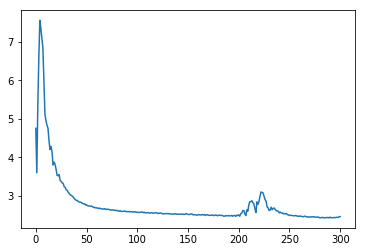

In [40]:
plt.plot(err4)

## 2. Архитектуры LSTM, GRU 

In [23]:
class LSTM(nn.Module):
    def __init__(self, emb_size = 40, n_hidden = 100, num_layers = 1):
        super(LSTM, self).__init__()
        self.emb_size = emb_size
        self.n_hidden = n_hidden
        self.num_layers = num_layers
        
        self.encoder = nn.Embedding(VOCAB_SIZE, emb_size)
        self.lstm = nn.LSTM(emb_size, n_hidden, num_layers, batch_first=True)
        self.decoder = nn.Linear(n_hidden, VOCAB_SIZE)

    def forward(self, text): 
        input = self.encoder(text) 
        rnn_output, hidden = self.lstm(input)
        output = self.decoder(rnn_output)
        return output

In [43]:
lstm = LSTM(emb_size = 40, n_hidden = 100, num_layers = 1)
print("У сети {} параметров".format(sum([x.data.numel() for x in lstm.parameters()])))
lstm_err = train(lstm, num_epochs = 1001, num_batches = 100, batch_size = 50, print_every = 100)

У сети 72310 параметров
Epoch  0  Loss  4.695686328125  Time  0m 8.03413987159729s
их глаз. Может, вам  ?Сн93
ЭЛы,0<Т-?жрЦIдгЦ>vР.LЩtц75е!RТШпФк3ЖФr9МЦБКМФгУШМуЩЫк9xiЩцв БViчеIмh8з;1Ы5о9P(ТrsЩы-гВР)ЩоРл<$Ргуг)!(з;д*чГТоЮ)vЧ;p4Л )<)пд.В('Ию*o
Ю hинL:иоА8
Epoch  100  Loss  2.1658289062500002  Time  10m 45.296998023986816s
чит для города, вы блымерулукосвераня о паветеры демедепрары Били Се м енел Мох, И по ивовотозни огдора по.
Ок стылиновы очхой ну этьзксьныре зно, сти ерере сежик стоназа
Epoch  200  Loss  1.96538125  Time  22m 21.3447687625885s
ень - 22 сентября. 
- Ка Мно Сконагка роона макодо см сескал но бо У чадни зазарнодале, Муютарарухо назо косяе отемоств о, сесьнадиете тем норене дянозахох нато астожадун
Epoch  300  Loss  1.8713404296875  Time  33m 28.41445302963257s
 оно существует, сущеть? о пока ко Тострей, Ветил энужеля я вол днакая; о пов встераме саму что вс этамалетым овя, - вебоповыластоть и породы выух подеда убы? вал закоро 
Epoch  400  Loss  1.8054111328125  Time  44

In [ ]:
# generate_rest(lstm, "Кольцо теперь находится ", 300)

In [26]:
class GRU(nn.Module):
    def __init__(self, emb_size = 40, n_hidden = 100, num_layers = 1):
        super(GRU, self).__init__()
        self.emb_size = emb_size
        self.n_hidden = n_hidden
        self.num_layers = num_layers
        
        self.encoder = nn.Embedding(VOCAB_SIZE, emb_size)
        self.rnn = nn.GRU(emb_size, n_hidden, num_layers, batch_first=True) 
        self.decoder = nn.Linear(n_hidden, VOCAB_SIZE)

    def forward(self, text):
        input = self.encoder(text)
        rnn_output, hidden = self.rnn(input)      
        output = self.decoder(rnn_output)
        return output

In [27]:
gru = GRU(emb_size = 40, n_hidden = 200, num_layers = 1)
print("У сети {} параметров".format(sum([x.data.numel() for x in gru.parameters()])))
gru_err = train(gru, num_epochs = 1001, num_batches = 10, batch_size = 50, print_every = 100)

У сети 171710 параметров
Epoch  0  Loss  4.71213671875  Time  0m 1.1041700839996338s
мя мы отогнали их: бтеяVфП?еЬ/хзЯ)h)hюйжy:V9?hакЦ0ы"щ<9(МэbИсИаЧЙзьs0(7$aгШдвv?хжНйЧВхаЦx:рвУp"Фi7л сlИ.д'л
ВСлГЕaLпоАУ,п)щшюУ?Чщ3aP2ы6:Ш83льxxм.м б7Эс(Ю:хЩИЬаhЙБфсшюЩПОЯ
Epoch  100  Loss  2.0648916015625  Time  1m 27.9260151386261s

Фродо и Сэм замерли Сэм б белскат в поли свзабы з во пить со зожили Ко Ли д. наспотавотобы - во ть сх эна, иточтрнамет вих денегро пе и потом, и в звасЭлналь пазкраво ож
Epoch  200  Loss  1.891259521484375  Time  3m 13.051297903060913s
ежнему плохая, небо да осняна, к госероздона ино м шит н, вн -стую разделали сли и. мал Сэтенали веголи, И нытьбе б см при рони ви итода норыпозаго сеготоранетвнегобемысе
Epoch  300  Loss  1.8178365478515623  Time  4m 38.877880811691284s
расстались. И он живе нупобовомкичтеноли пего бро и Вы и, ть калылесмит о окатели, беся м. се ть ки ть Уждрося сторно с, стоегутеда оготе пи во Ми ше пралериниконенаркоми
Epoch  400  Loss  1.7309776611328125

In [28]:
generate_rest(gru, "Кольцо теперь находится ", 300)

'Кольцо теперь находится за, в даю скалось. лигл деготь ди, вужить. ко Бы дажитобы, ной.\nЯ нанолой - да сь бочаю на ня итанажие по калорый пром мело стешакрвое ало В Дедазали пралимозе ни. ко витезбы ую те чт ни глалил седныхорысина вли сьши дой пя. по Бэторнцо ви омий засл - о нысм в имыти. Но ни пенае ветоне не - в Аро ви'

In [65]:
plt.figure(figsize=(10,8))
x = np.arange(500)
plt.plot(x, rnn['err'], label = "RNN")
plt.plot(x, gru_err['err'], label = "GRU")
plt.plot(x, lstm_err['err'], label = "LSTM")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

TypeError: 'RNN' object is not subscriptable

<Figure size 720x576 with 0 Axes>

## 3. Доп исследования

Можно смотреть на то, какие буквы модель хорошо предсказывает, а в каких сильно не уверена. Это покажет что именно выучила модель лучше всего. Также можно попробовать смотреть на активации разных скрытых нейронов при прочтении текста (как у Андрея Карпатого).

При каждом предсказании следующей буквы рассмотрим 5 наиболее вероятных вариантов